# Run PESTPP-IES

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu


In [ ]:
t_d = "template"
m_d = "master_ies"

In [ ]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
pst.write_par_summary_table(filename="none")

### Run PESTPP-IES in original mode and post process

In [ ]:
pst.pestpp_options["ies_num_reals"] = 30
pst.pestpp_options["ies_par_en"] = "sweep_in.csv"
pst.control_data.noptmax = 4

In [ ]:
pst.write(os.path.join(t_d,"freyberg_ies.pst"))

In [ ]:
pyemu.os_utils.start_slaves(t_d,"pestpp-ies","freyberg_ies.pst",num_slaves=20,master_dir=m_d)

A cheap phi progress plot

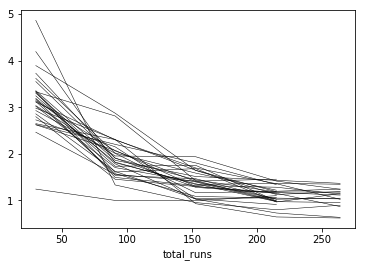

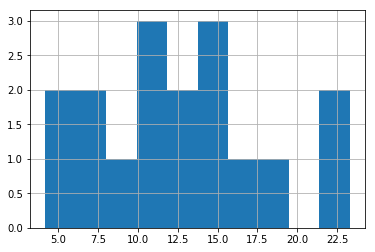

In [16]:
phi = pd.read_csv(os.path.join(m_d,"freyberg_ies.phi.actual.csv"),index_col=0)
phi.index = phi.total_runs
phi.iloc[:,6:].apply(np.log10).plot(legend=False,lw=0.5,color='k')
plt.show()
phi.iloc[-1,6:].hist()

Crushed phi!  this must be the perfect model!

Plot forecast prior and posterior histograms with "truth" (red line)

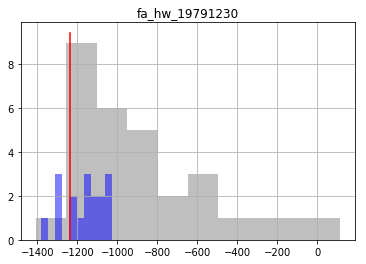

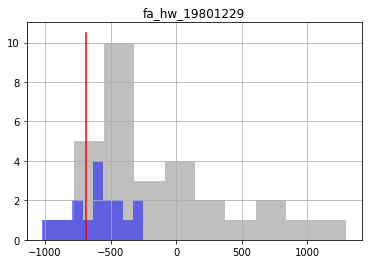

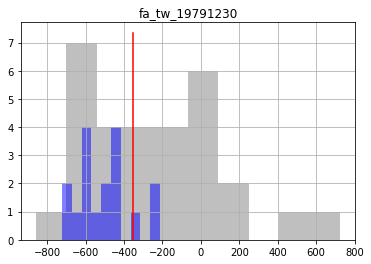

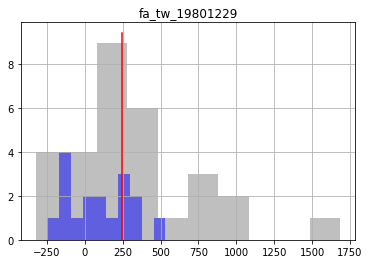

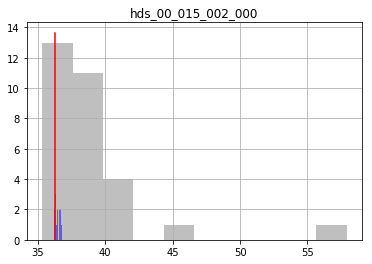

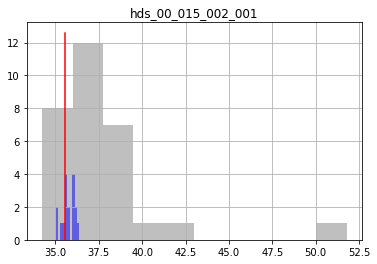

In [13]:
oe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies.0.obs.csv"),index_col=0)
oe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies.{0}.obs.csv".format(pst.control_data.noptmax)),index_col=0)
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    oe_pr.loc[:,forecast].hist(ax=ax,color="0.5",alpha=0.5)
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5)
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    ax.set_title(forecast)
    plt.show()

Plot parameter histograms by group

<Figure size 576x756 with 0 Axes>

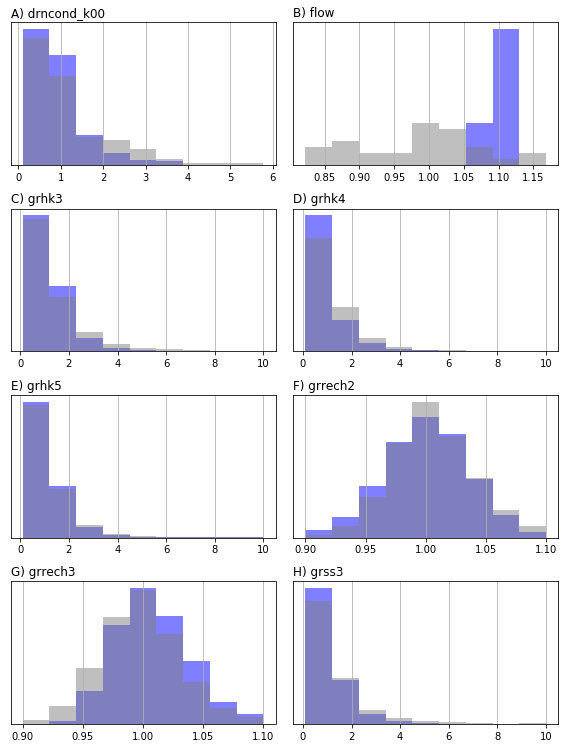

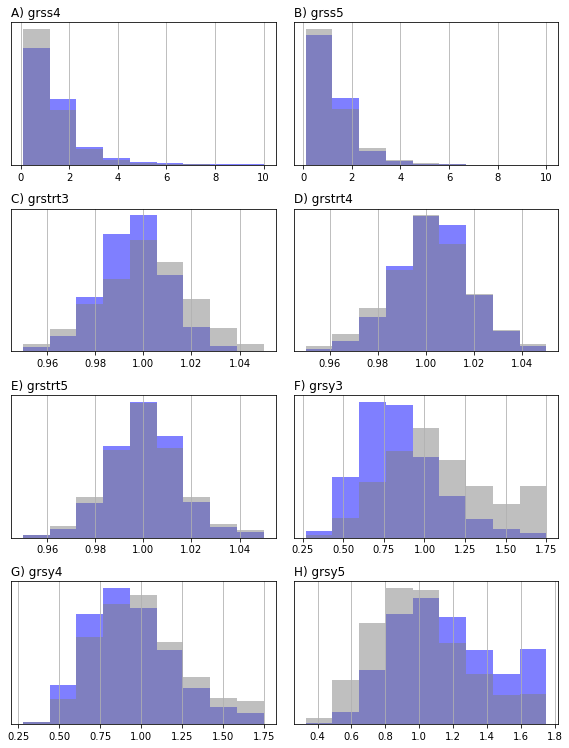

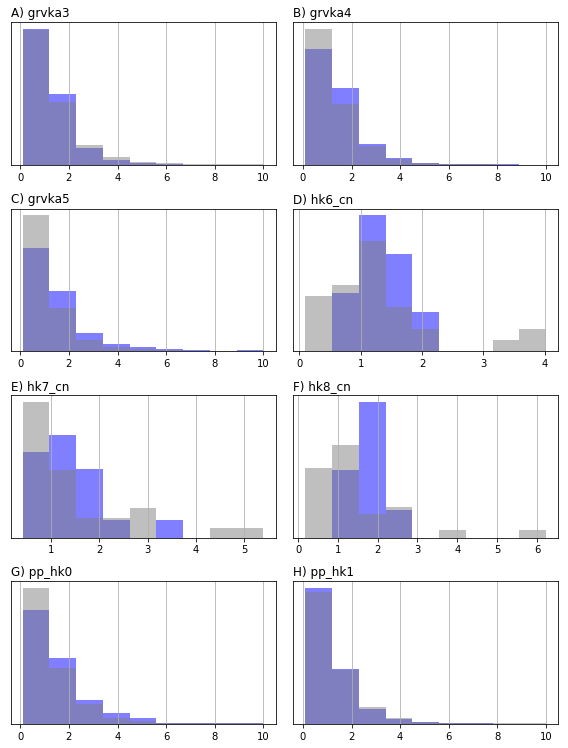

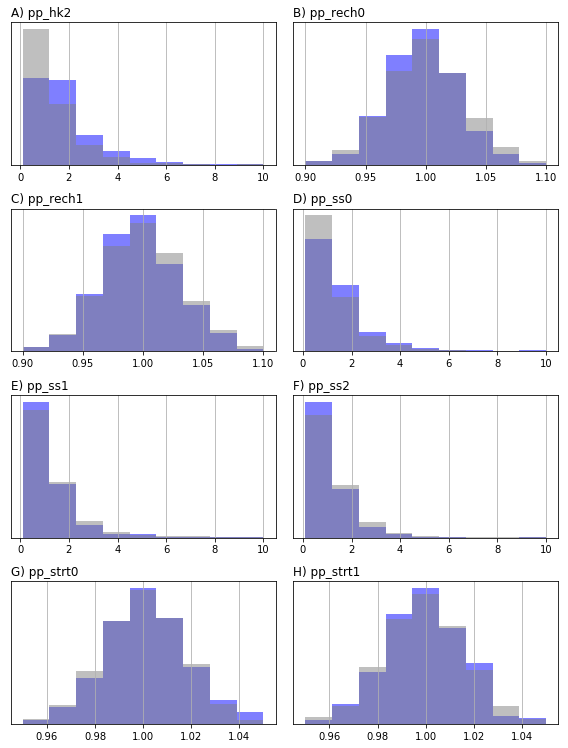

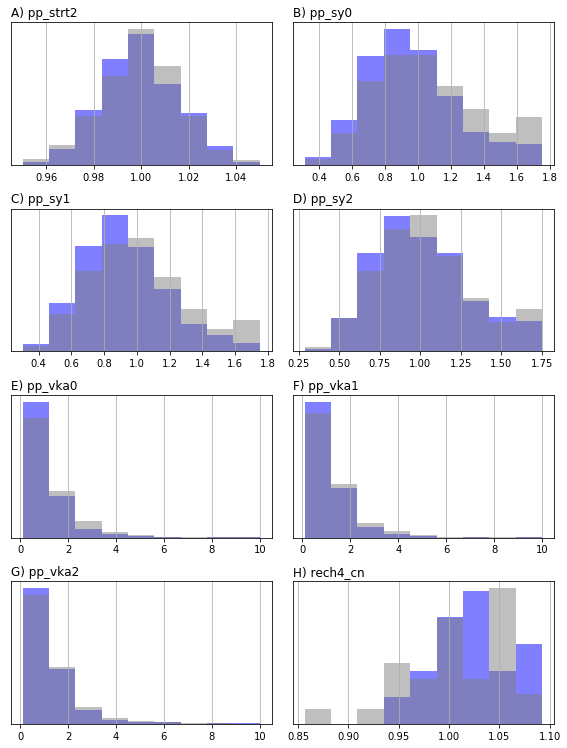

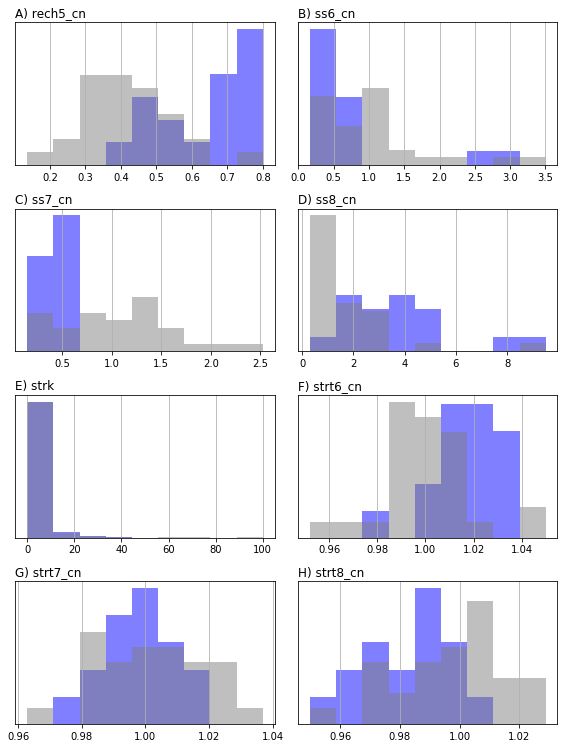

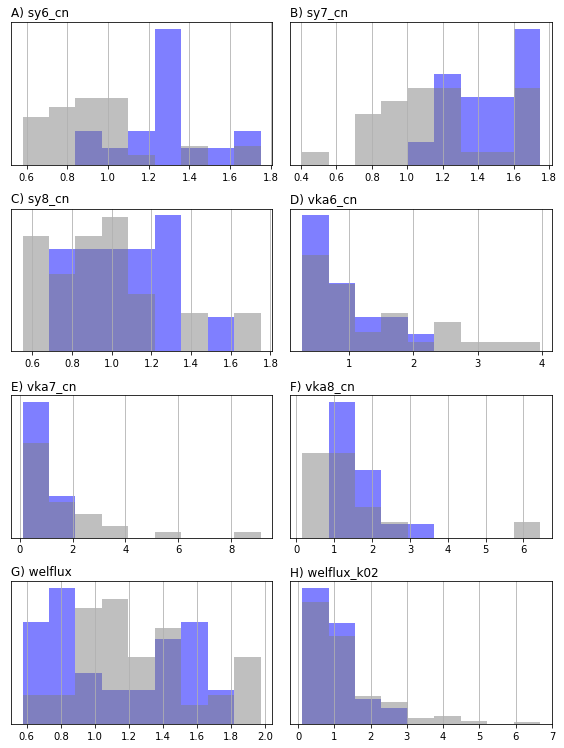

In [17]:
pe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies.0.par.csv"),index_col=0)
pe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies.{0}.par.csv".format(pst.control_data.noptmax)),index_col=0)
par = pst.parameter_data
pdict = par.groupby("pargp").groups
pyemu.plot_utils.ensemble_helper({"0.5":pe_pr,"b":pe_pt},plot_cols=pdict)

[<Figure size 576x756 with 0 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

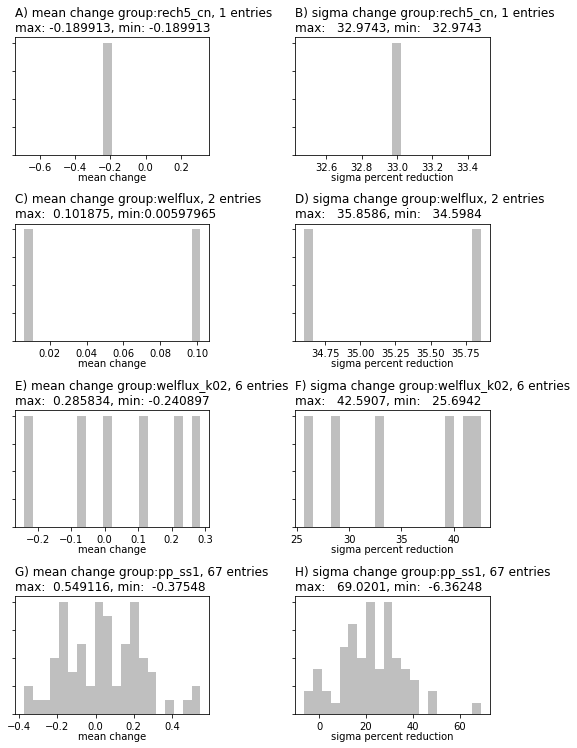

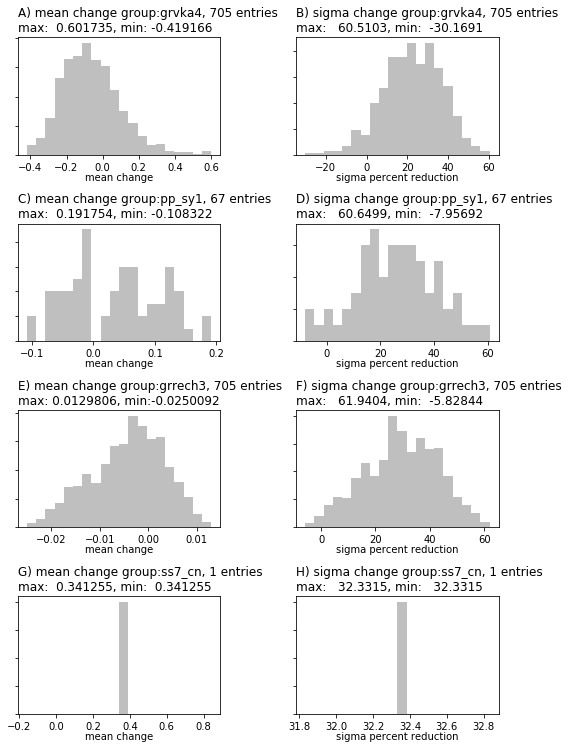

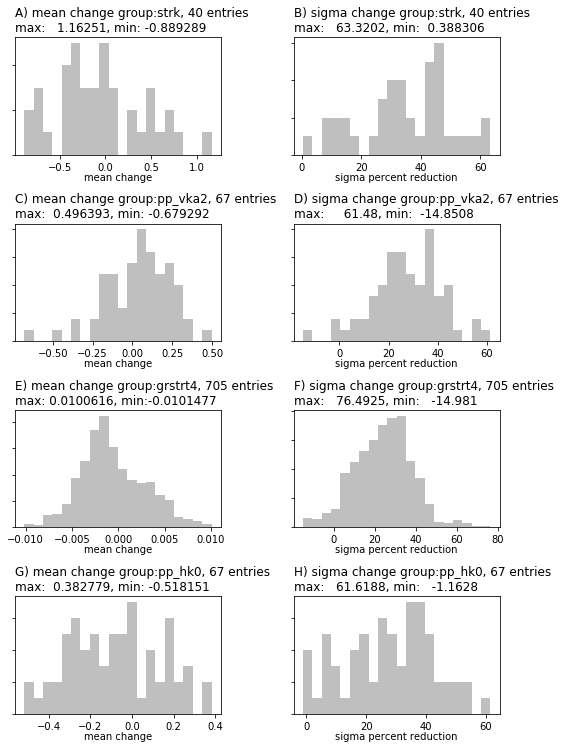

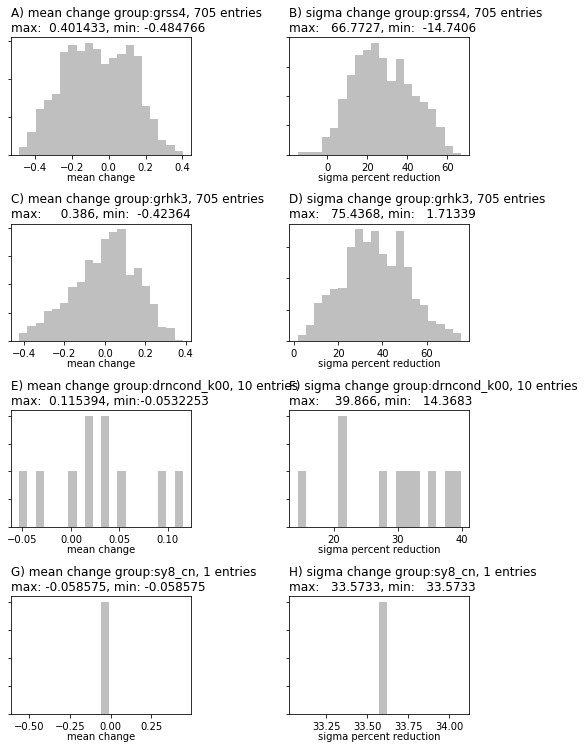

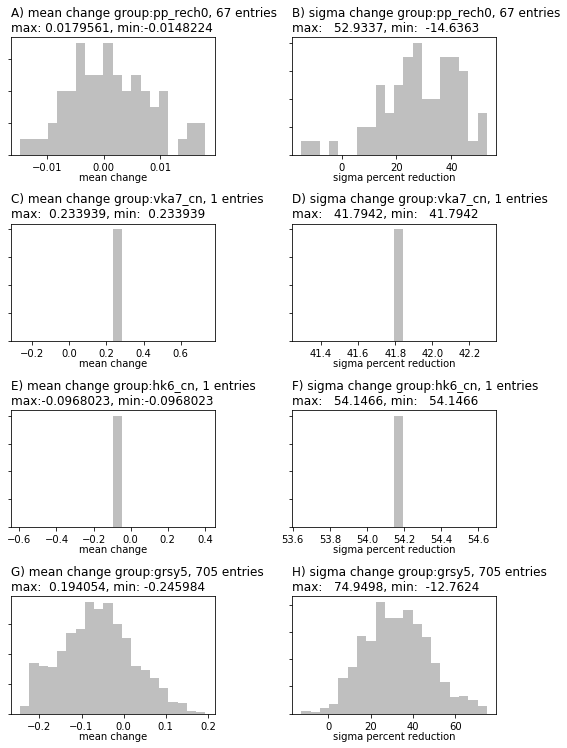

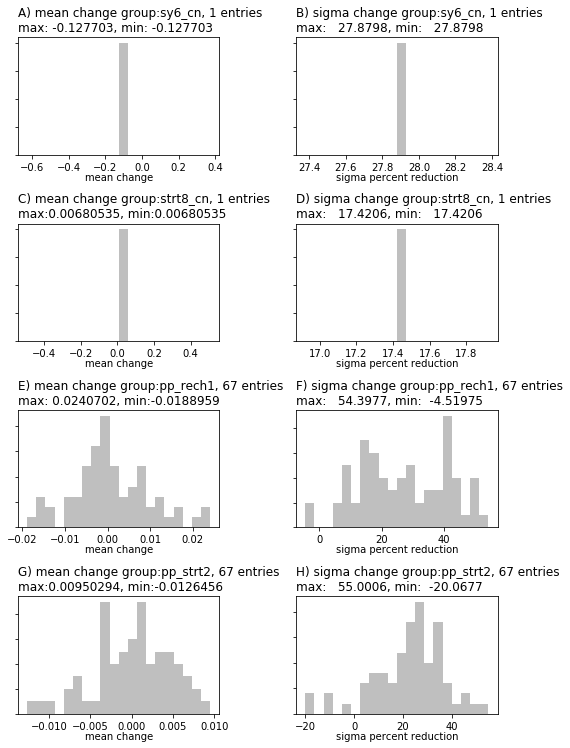

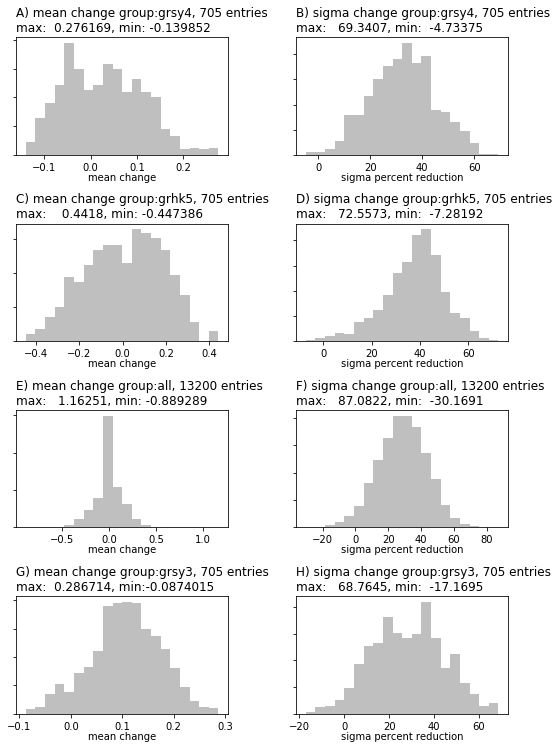

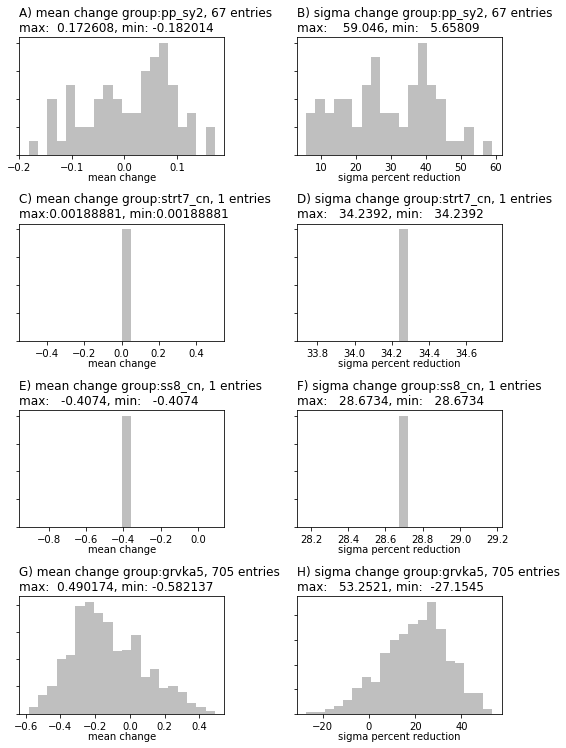

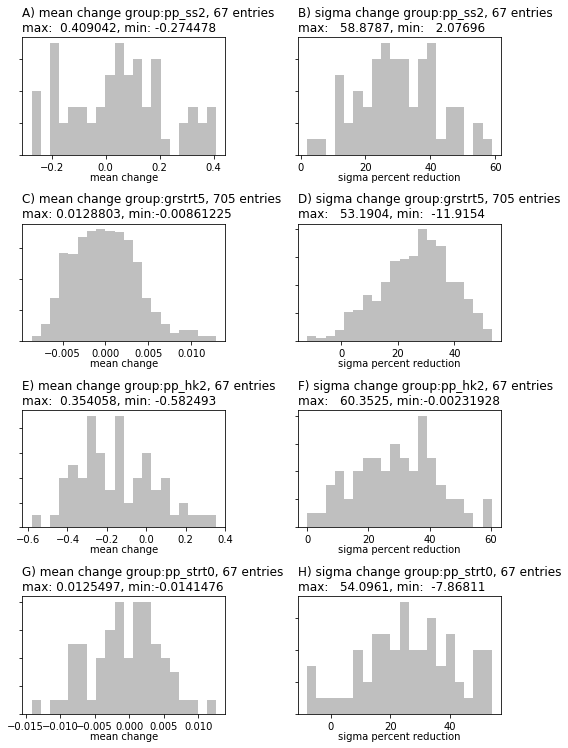

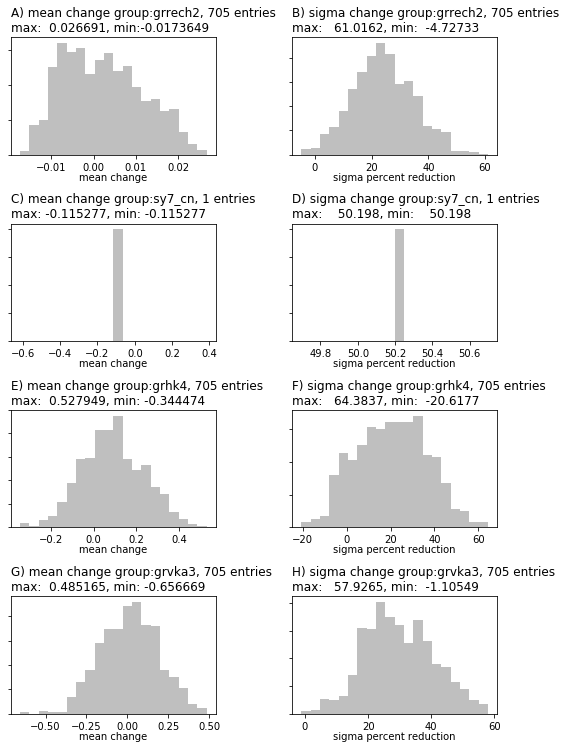

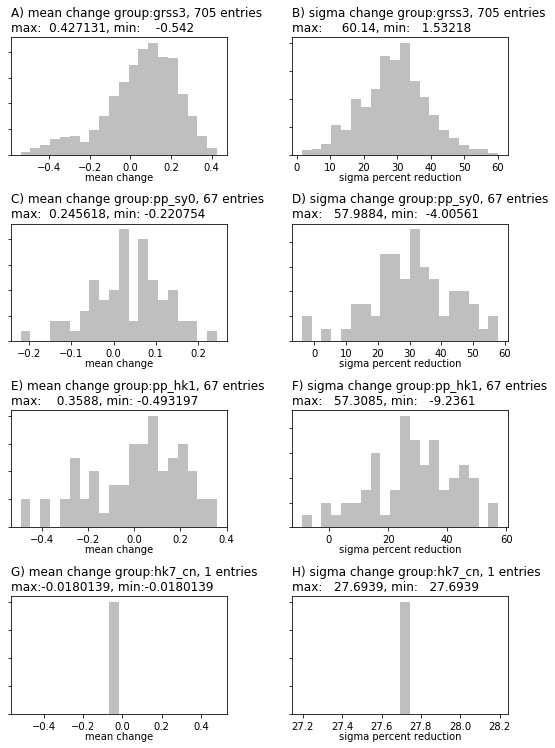

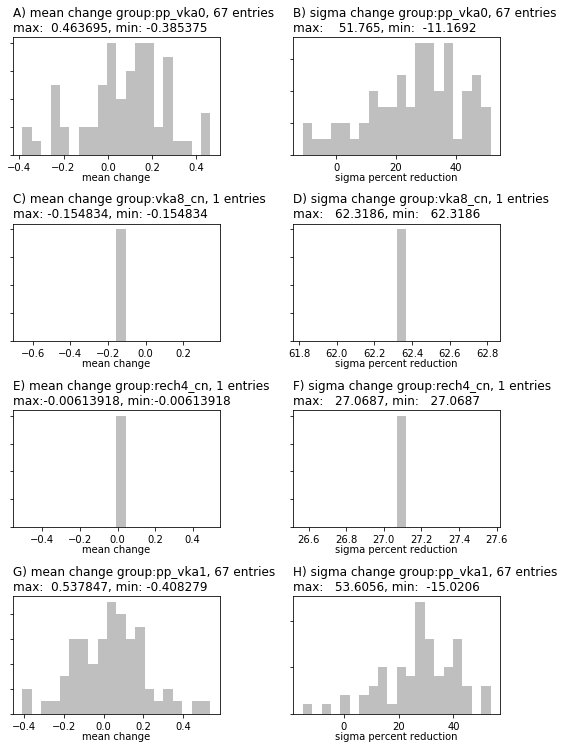

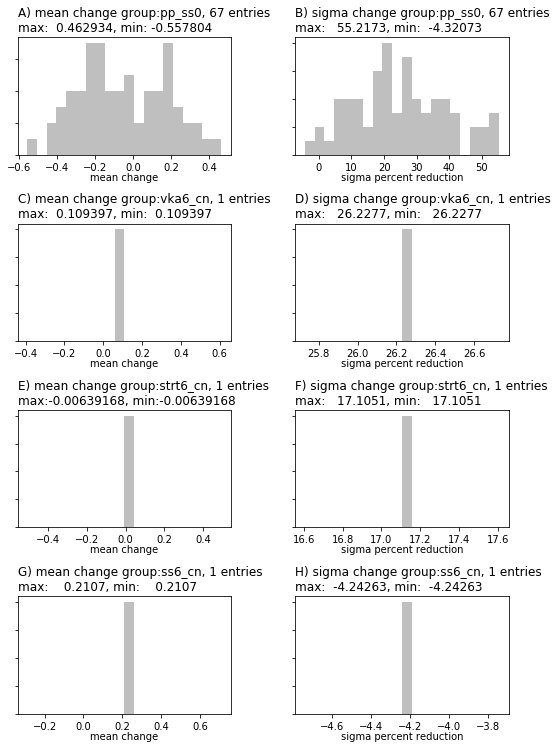

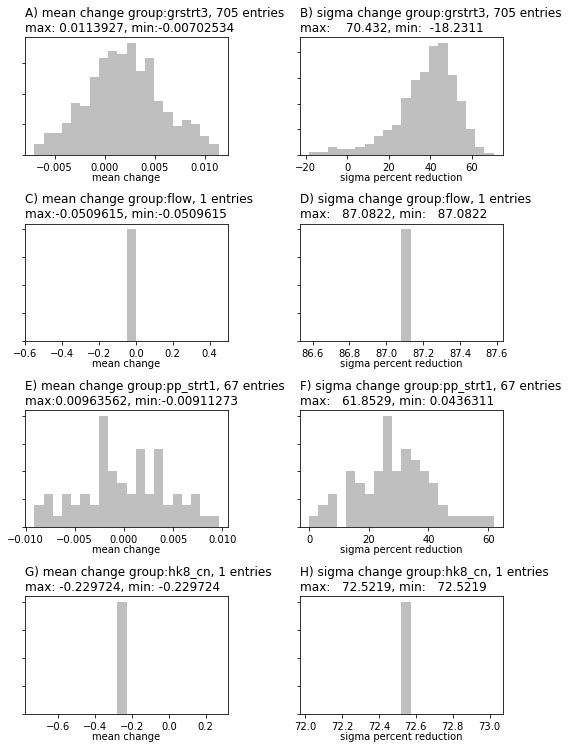

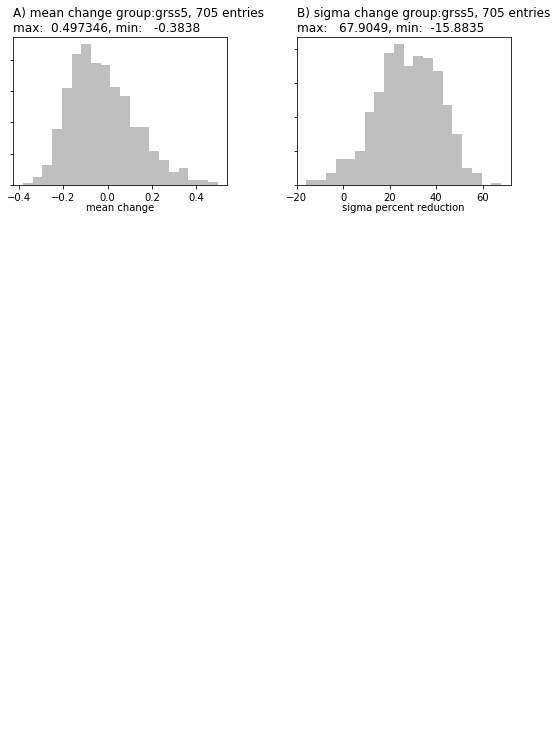

In [18]:
pyemu.plot_utils.ensemble_change_summary(pe_pr,pe_pt,pst=pst,bins=20)

Those are some pretty extreme variance reductions, considering we are conditioning 10K+ pars on 13 water levels and one flux.  This is a well-known issue with low-rank ensemble method ("ensemble collapse").  This is over come with localization....

### PESTPP-IES with simple temporal localization

Now let's add some localization.  The obvious stuff is temporal - scenario parameters can't influence historic observations (and the inverse is true) so let's tell PESTPP-IES about this:

In [19]:
par = pst.parameter_data
#parameter groups for future recharge
scen_groups = ["grrech3","pp_rech1","rech5_cn"]
scen_pars = par.loc[par.pargp.apply(lambda x: x in scen_groups),"parnme"].tolist()
scen_pars.append("welflux_001")

In [20]:
loc = pyemu.Matrix.from_names(pst.nnz_obs_names,pst.par_groups).to_dataframe()
loc.loc[:,:]= 1.0
loc.loc[:,scen_groups] = 0.0
pyemu.Matrix.from_dataframe(loc).to_ascii(os.path.join(t_d,"loc.mat"))

In [25]:
pst.pestpp_options["ies_localizer"] = "loc.mat"
pst.write(os.path.join(t_d,"freyberg_ies.pst"))
pyemu.os_utils.start_slaves(t_d,"pestpp-ies","freyberg_ies.pst",num_slaves=20,master_dir=m_d)

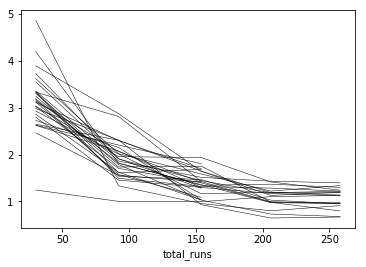

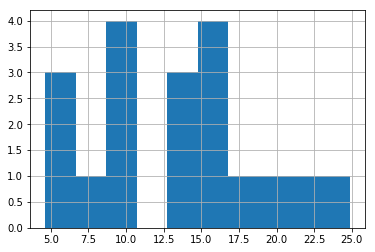

In [29]:
phi = pd.read_csv(os.path.join(m_d,"freyberg_ies.phi.actual.csv"),index_col=0)
phi.index = phi.total_runs
phi.iloc[:,6:].apply(np.log10).plot(legend=False,lw=0.5,color='k')
plt.show()
phi.iloc[-1,6:].hist()

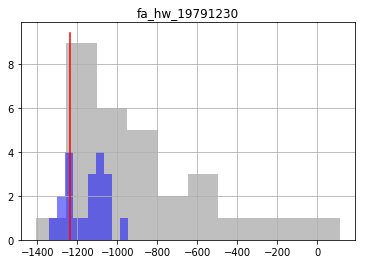

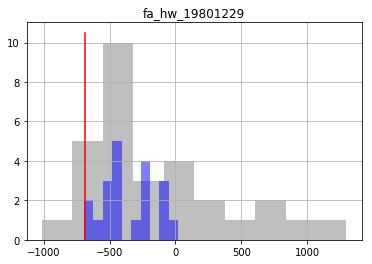

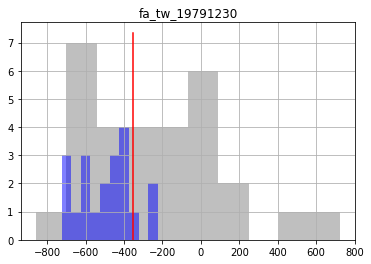

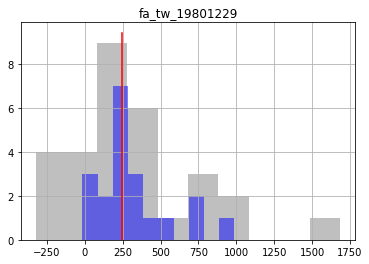

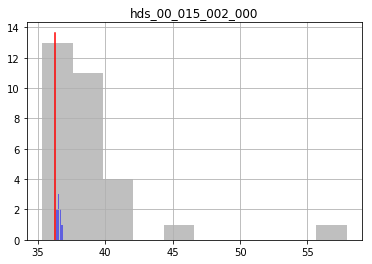

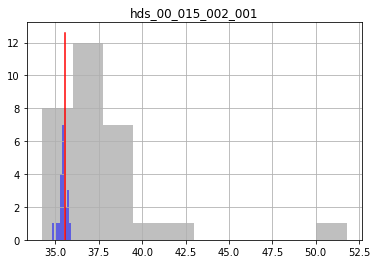

In [30]:
oe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies.0.obs.csv"),index_col=0)
oe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies.{0}.obs.csv".format(pst.control_data.noptmax)),index_col=0)
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    oe_pr.loc[:,forecast].hist(ax=ax,color="0.5",alpha=0.5)
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5)
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    ax.set_title(forecast)
    plt.show()

(30, 13200) (20, 13200)


[<Figure size 576x756 with 0 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

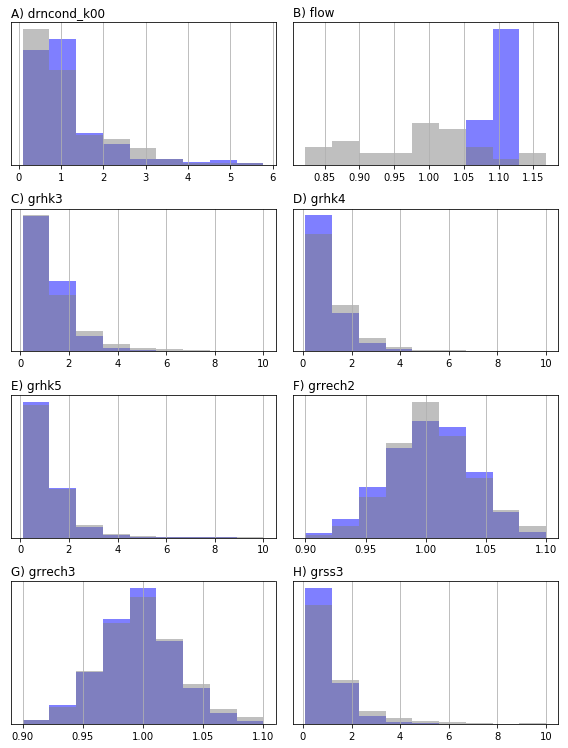

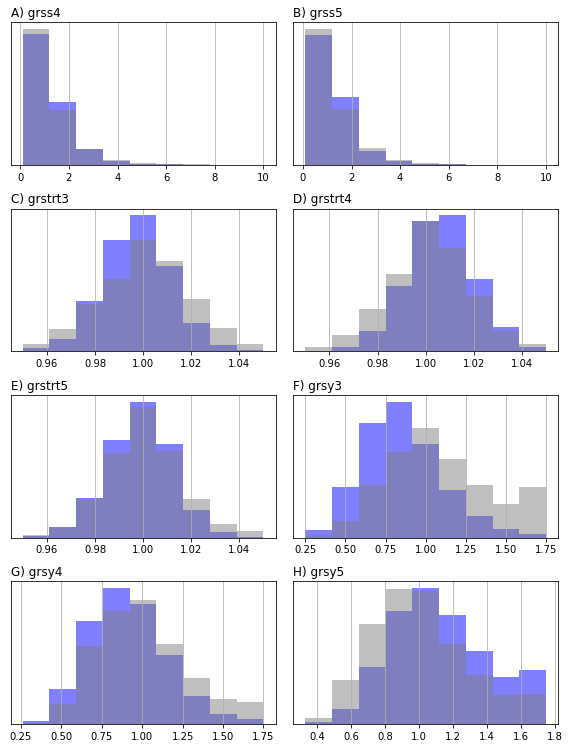

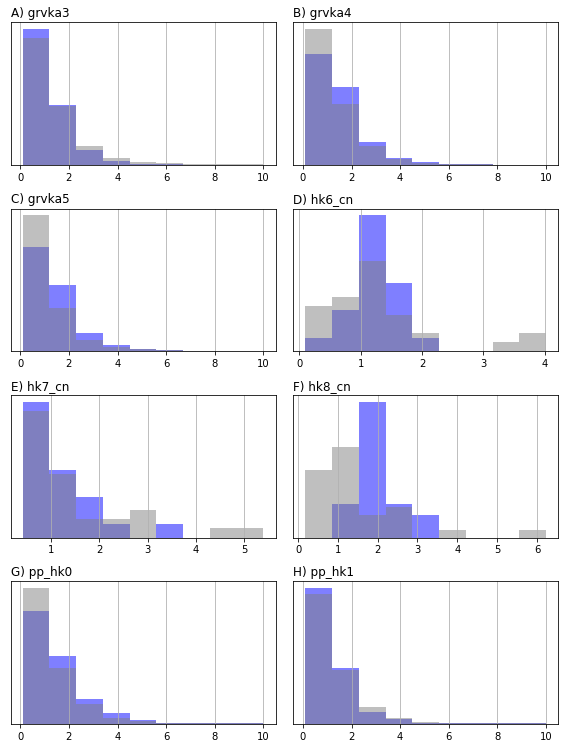

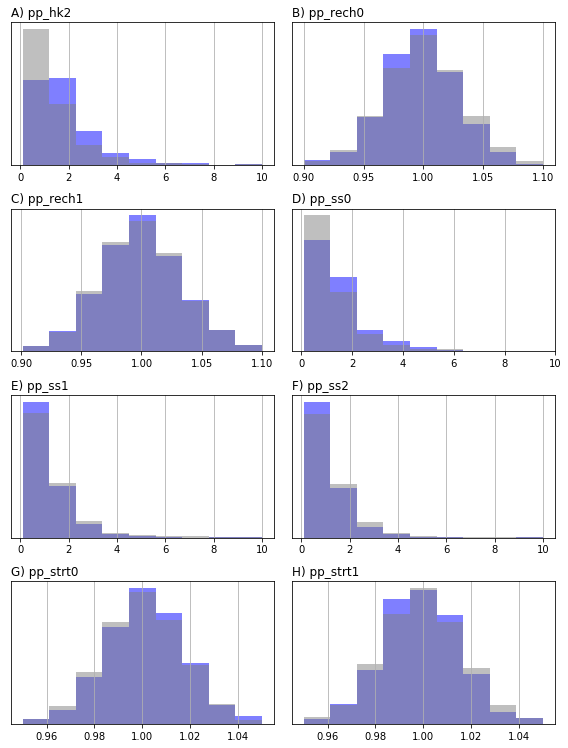

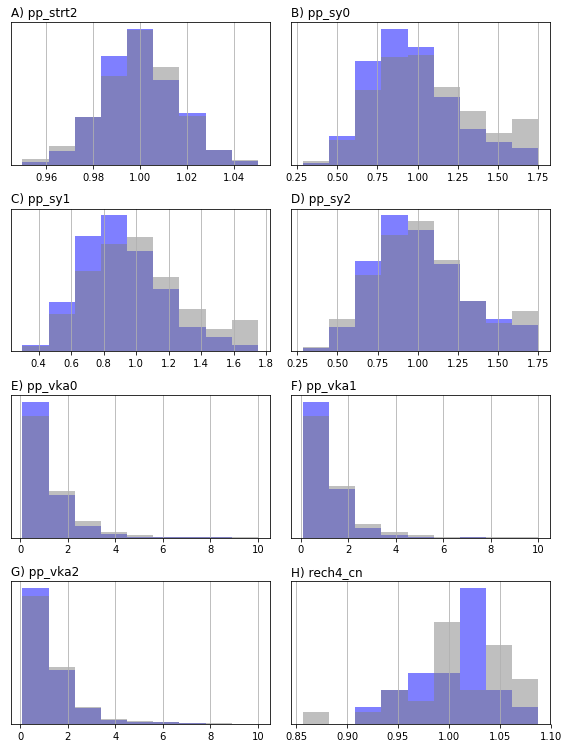

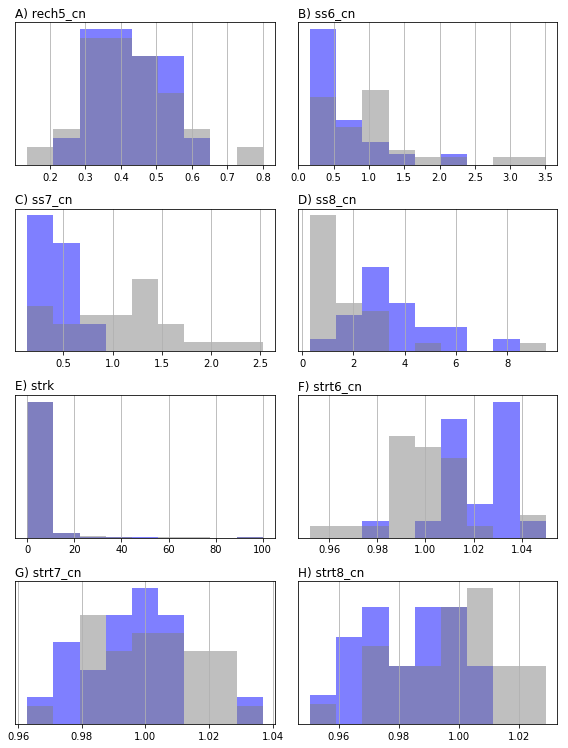

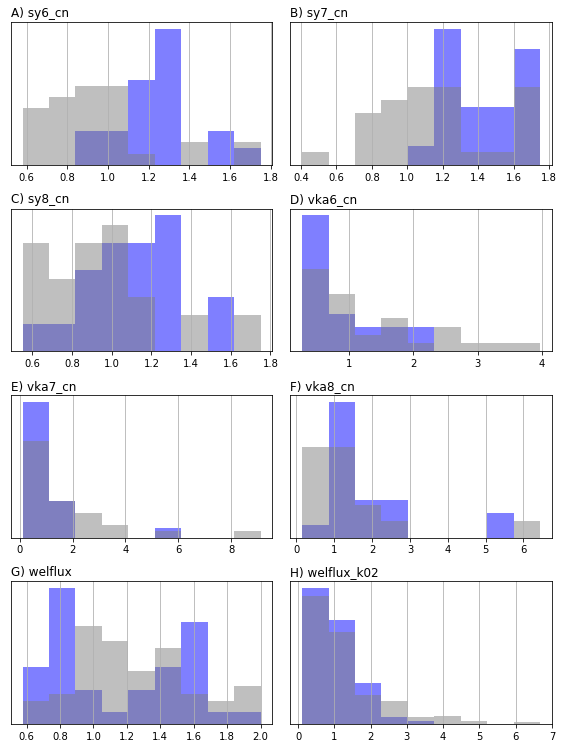

<Figure size 576x756 with 0 Axes>

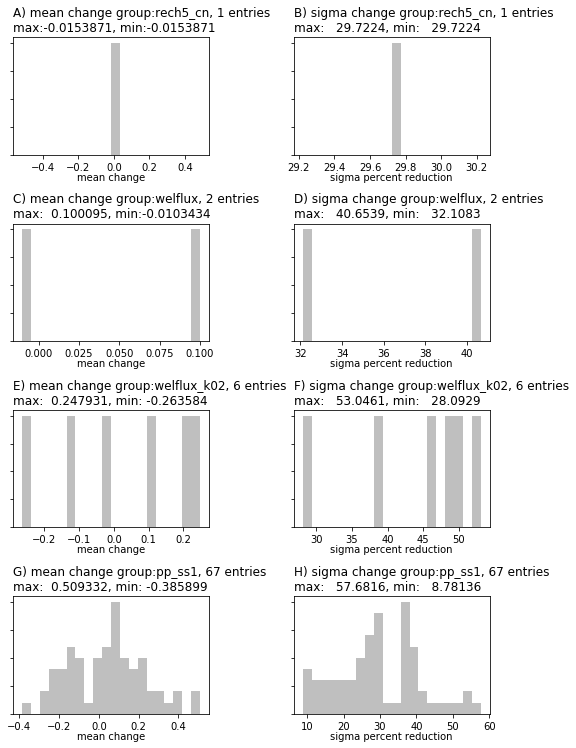

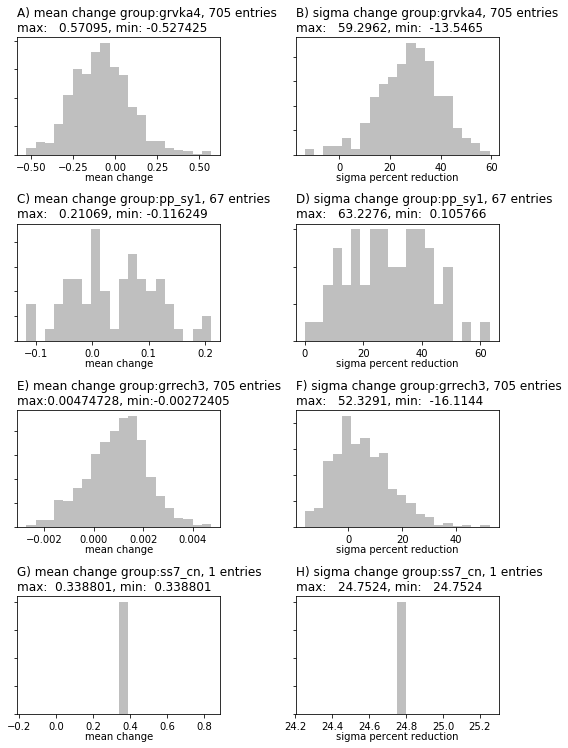

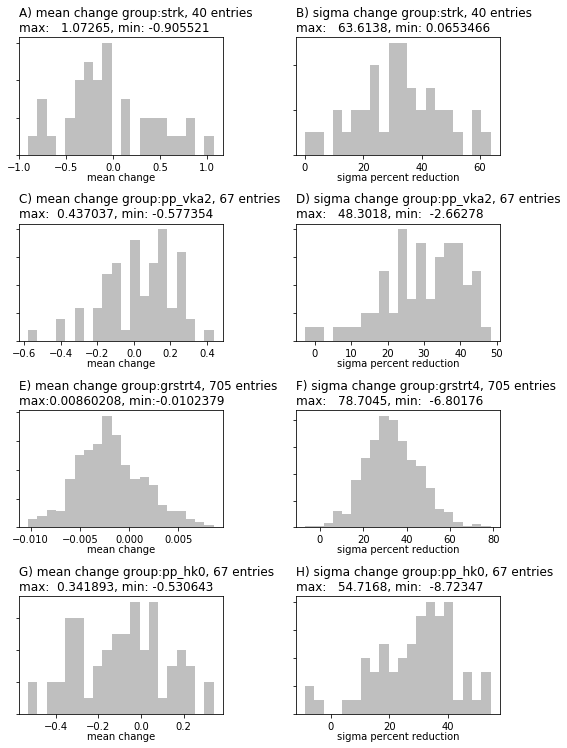

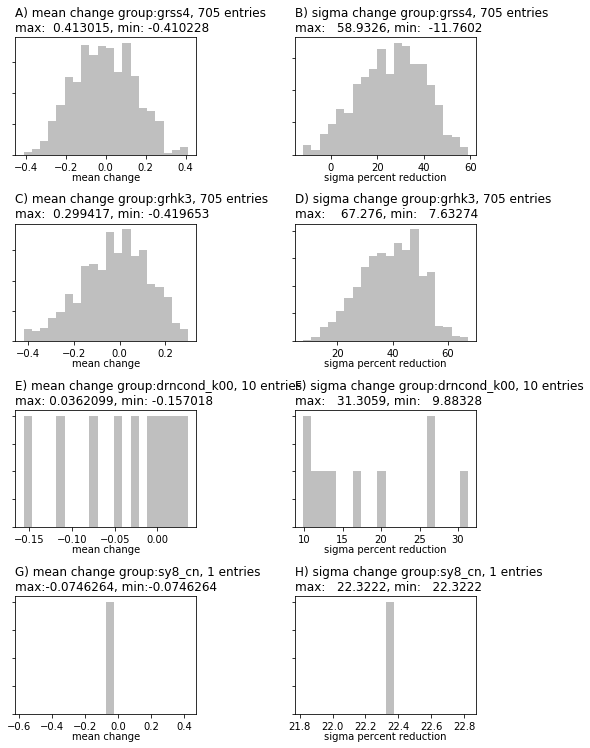

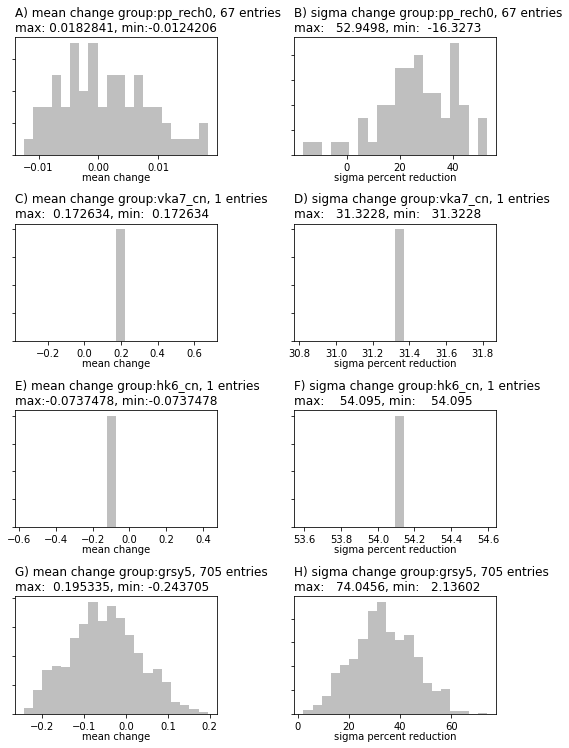

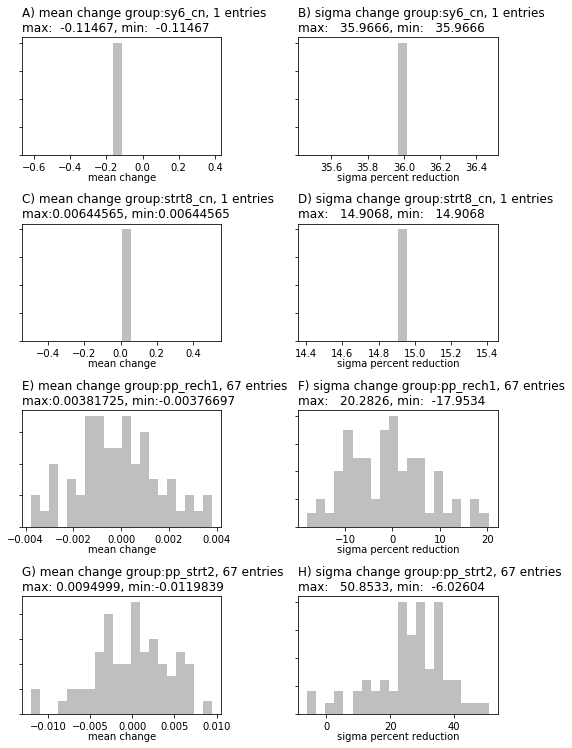

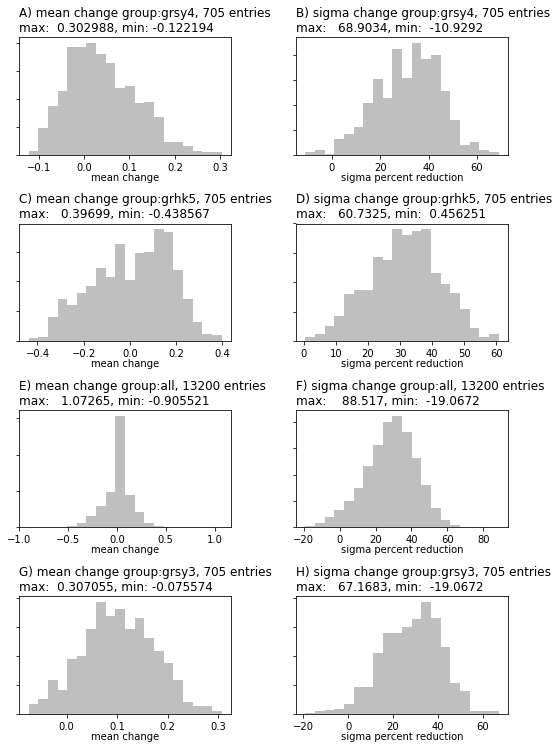

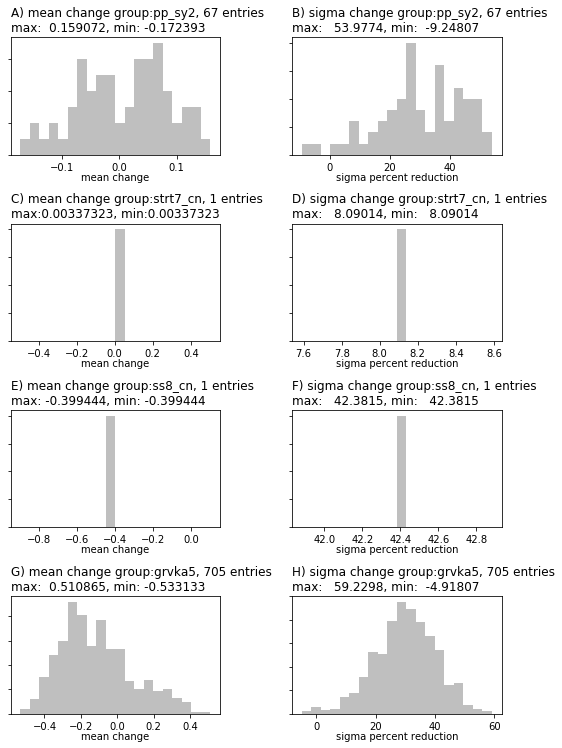

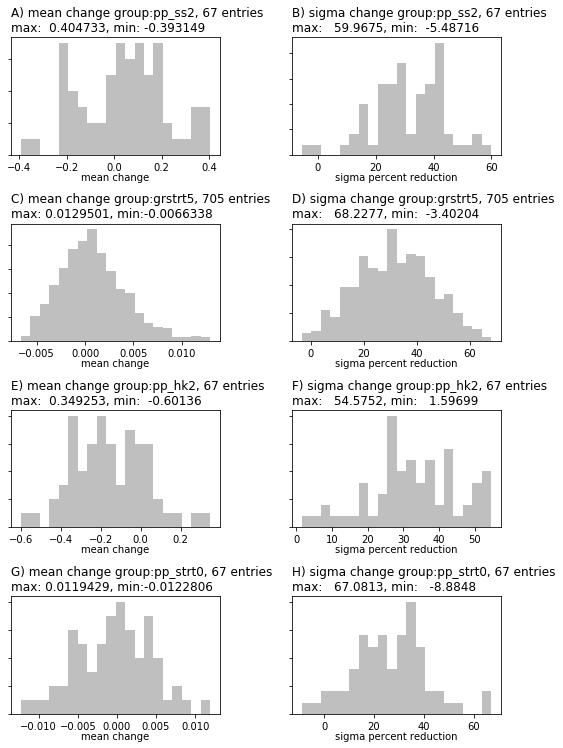

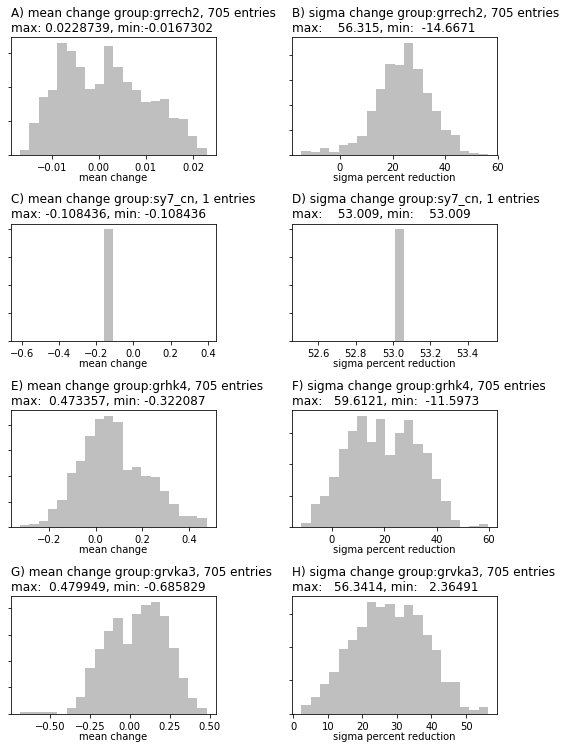

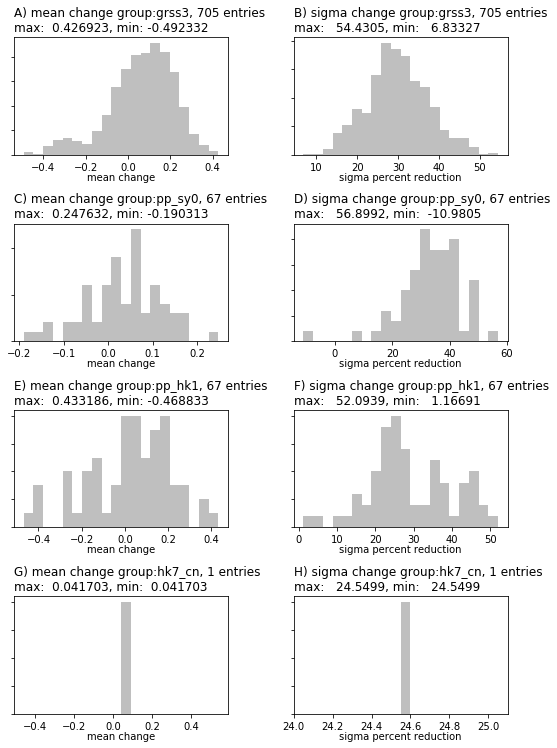

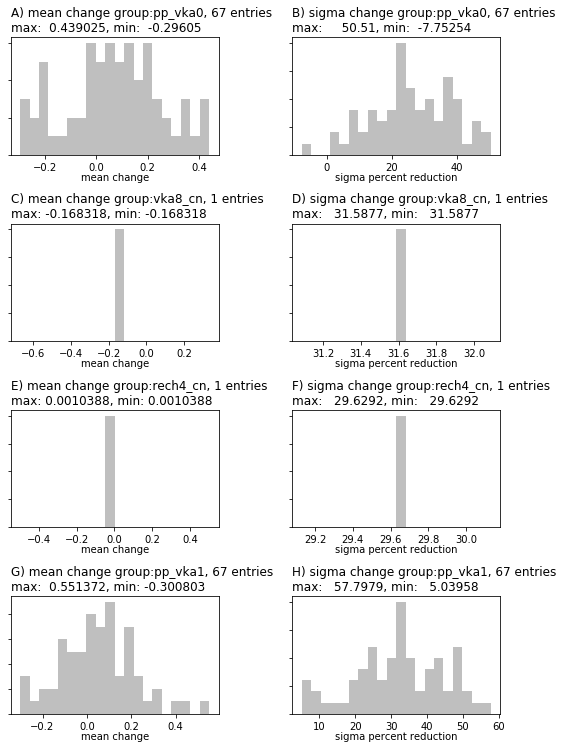

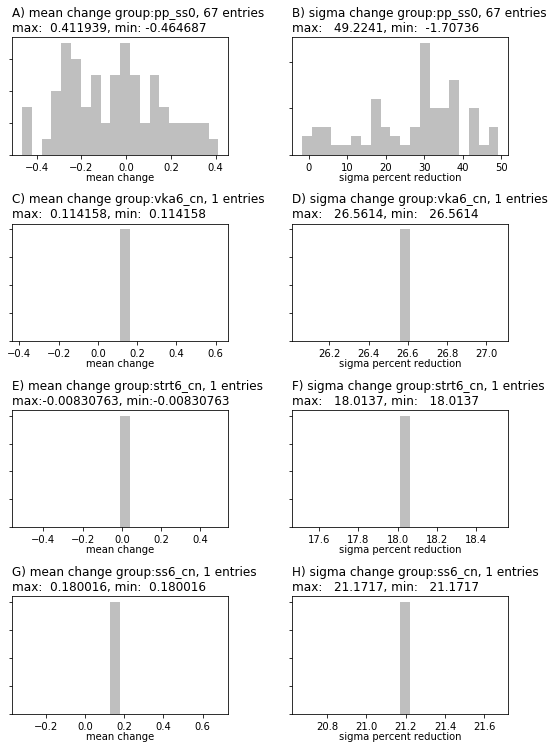

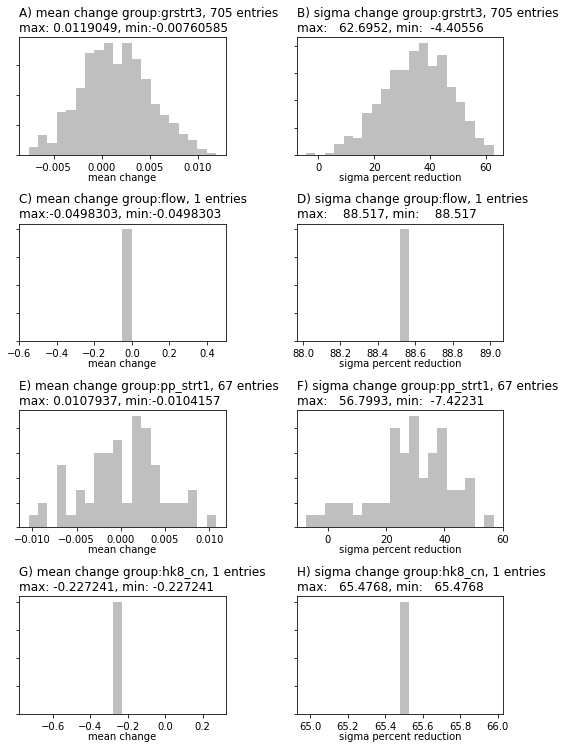

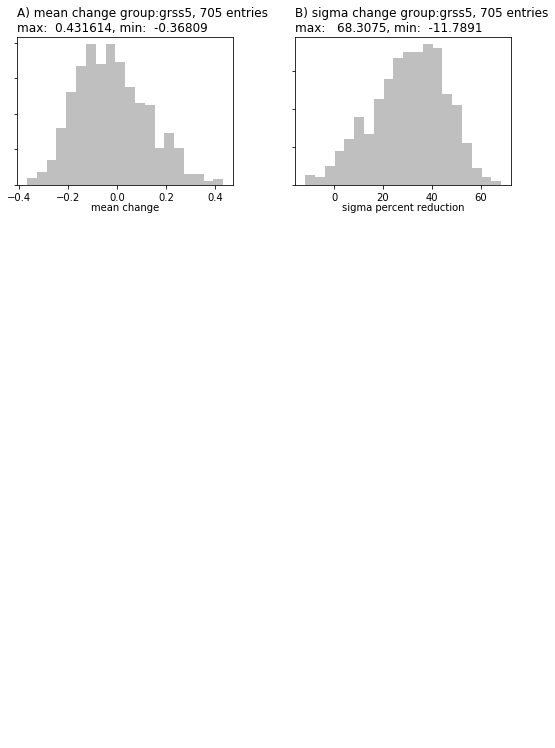

In [37]:
pe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies.0.par.csv"),index_col=0)
pe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies.{0}.par.csv".format(pst.control_data.noptmax)),index_col=0)
#pe_pr.index = pe_pt.index
#par = pst.parameter_data
print(pe_pr.shape,pe_pt.shape)
pdict = par.groupby("pargp").groups
pyemu.plot_utils.ensemble_helper({"0.5":pe_pr,"b":pe_pt},plot_cols=pdict)
pyemu.plot_utils.ensemble_change_summary(pe_pr,pe_pt,pst=pst,bins=20)

### PESTPP-IES with par-by-par distance based localization


In [38]:
m = flopy.modflow.Modflow.load("freyberg.nam",model_ws="template")

In [39]:
par = pst.parameter_data

gr_par = par.loc[par.pargp.apply(lambda x: "gr" in x),:].copy()
gr_par.groupby("pargp").groups
gr_par.loc[:,"i"] = gr_par.parnme.apply(lambda x: int(x[-6:-3]))
gr_par.loc[:,"j"] = gr_par.parnme.apply(lambda x: int(x[-3:]))
gr_par.loc[:,"x"] = gr_par.apply(lambda x: m.sr.xcentergrid[x.i,x.j],axis=1)
gr_par.loc[:,"y"] = gr_par.apply(lambda x: m.sr.ycentergrid[x.i,x.j],axis=1)

obs = pst.observation_data

nobs = obs.loc[obs.obgnme=="calhead",:].copy()
nobs.loc[:,"i"] = nobs.obsnme.apply(lambda x: int(x.split('_')[2]))
nobs.loc[:,"j"] = nobs.obsnme.apply(lambda x: int(x.split('_')[3]))
nobs.loc[:,"x"] = nobs.apply(lambda x: m.sr.xcentergrid[x.i,x.j],axis=1)
nobs.loc[:,"y"] = nobs.apply(lambda x: m.sr.ycentergrid[x.i,x.j],axis=1)

pp_tpl = [f for f in os.listdir(t_d) if "pp" in f and f.endswith(".tpl")]
pp_tpl_dfs = [pyemu.pp_utils.pp_tpl_to_dataframe(os.path.join(t_d,f)) for f in pp_tpl]
pp_par = pd.concat(pp_tpl_dfs)
pp_par.index = pp_par.parnme
#pp_par = par.loc[par.pargp.apply(lambda x: "pp" in x),:].copy()


In [40]:
loc = pyemu.Matrix.from_names(pst.nnz_obs_names,pst.par_names).to_dataframe()
loc.loc[:,:] = 1.0
loc_dist = 5000.0
for oname in obs.loc[obs.obgnme=="calhead","obsnme"]:
    xx,yy = nobs.loc[oname,['x','y']]
    
    gr_par.loc[:,"dist"] = gr_par.apply(lambda x: (x.x - xx)**2 + (x.y - yy)**2,axis=1).apply(np.sqrt)
    gr_too_far = gr_par.loc[gr_par.dist > loc_dist,"parnme"]
    loc.loc[:,gr_too_far] = 0.0
    
    pp_par.loc[:,"dist"] = pp_par.apply(lambda x: (x.x - xx)**2 + (x.y - yy)**2,axis=1).apply(np.sqrt)
    pp_too_far = pp_par.loc[pp_par.dist > loc_dist,"parnme"]
    loc.loc[oname,pp_too_far] = 0.0
    print(oname,gr_too_far.shape[0]/gr_par.shape[0],pp_too_far.shape[0]/pp_par.shape[0])
    
loc.loc[:,scen_pars] = 0.0
spars = par.loc[par.parnme.apply(lambda x: "ss" in x or "sy" in x),"parnme"]
loc.loc[:,spars] = 0.0
loc.sum(axis=1)

hds_00_002_009_000 0.46382978723404256 0.4925373134328358
hds_00_002_015_000 0.4794326241134752 0.5074626865671642
hds_00_003_008_000 0.43829787234042555 0.43283582089552236
hds_00_009_001_000 0.3304964539007092 0.2835820895522388
hds_00_013_010_000 0.15319148936170213 0.14925373134328357
hds_00_015_016_000 0.13900709219858157 0.11940298507462686
hds_00_021_010_000 0.06950354609929078 0.07462686567164178
hds_00_022_015_000 0.12198581560283688 0.13432835820895522
hds_00_024_004_000 0.17872340425531916 0.1791044776119403
hds_00_026_006_000 0.2198581560283688 0.208955223880597
hds_00_029_015_000 0.29929078014184396 0.29850746268656714
hds_00_033_007_000 0.3829787234042553 0.3880597014925373
hds_00_034_010_000 0.4 0.40298507462686567


fo_39_19791230        1488.0
hds_00_002_009_000    1158.0
hds_00_002_015_000    1148.0
hds_00_003_008_000    1198.0
hds_00_009_001_000    1298.0
hds_00_013_010_000    1388.0
hds_00_015_016_000    1408.0
hds_00_021_010_000    1438.0
hds_00_022_015_000    1398.0
hds_00_024_004_000    1368.0
hds_00_026_006_000    1348.0
hds_00_029_015_000    1288.0
hds_00_033_007_000    1228.0
hds_00_034_010_000    1218.0
dtype: float64

In [41]:
pyemu.Matrix.from_dataframe(loc).to_binary(os.path.join(t_d,"loc.jcb"))
pst.pestpp_options["ies_localizer"] = "loc.jcb"
pst.write(os.path.join(t_d,"freyberg_ies.pst"))

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
<class 'numpy.ndarray'>


In [42]:
pyemu.os_utils.start_slaves(t_d,"pestpp-ies","freyberg_ies.pst",num_slaves=20,master_dir=m_d)

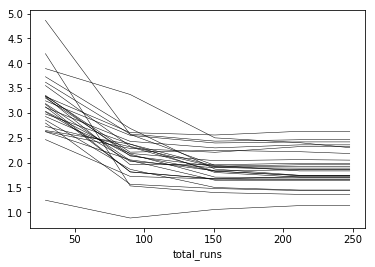

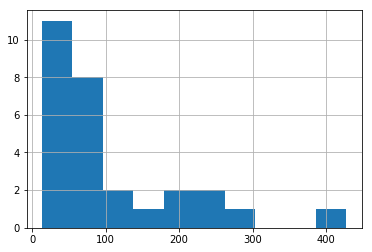

In [43]:
phi = pd.read_csv(os.path.join(m_d,"freyberg_ies.phi.actual.csv"),index_col=0)
phi.index = phi.total_runs
phi.iloc[:,6:].apply(np.log10).plot(legend=False,lw=0.5,color='k')
plt.show()
phi.iloc[-1,6:].hist()

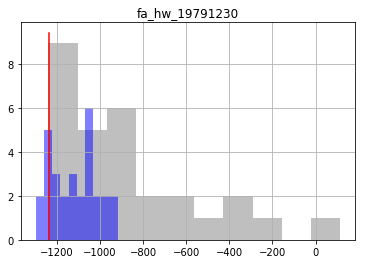

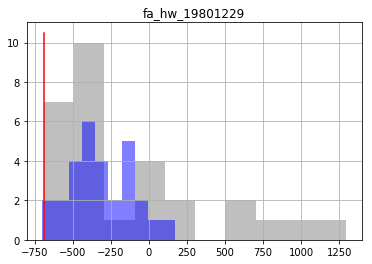

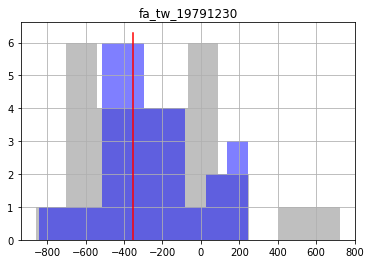

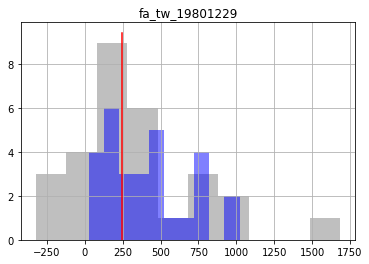

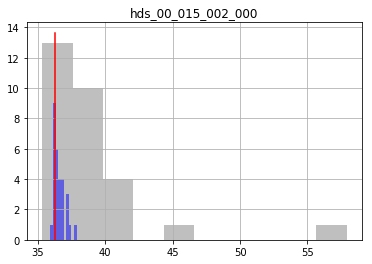

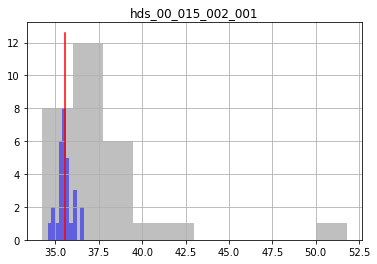

In [45]:
oe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies.0.obs.csv"),index_col=0)
oe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies.{0}.obs.csv".format(pst.control_data.noptmax)),index_col=0)
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    oe_pr.loc[:,forecast].hist(ax=ax,color="0.5",alpha=0.5)
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5)
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    ax.set_title(forecast)
    plt.show()

[<Figure size 576x756 with 0 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

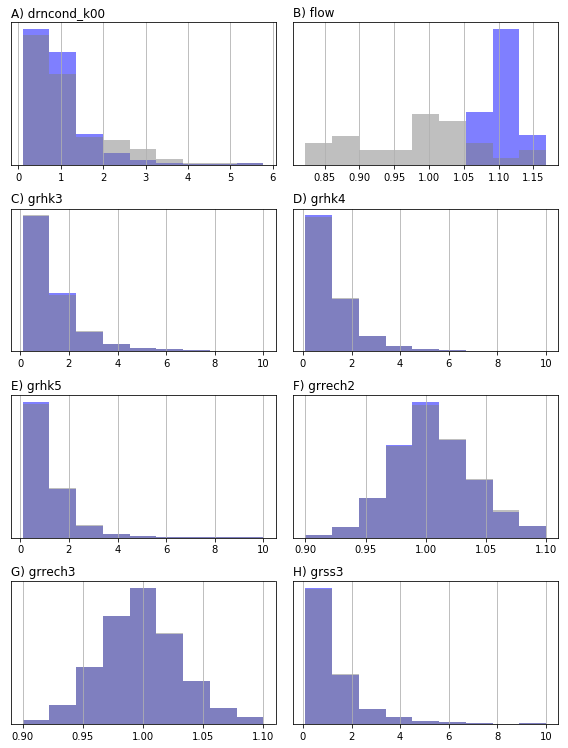

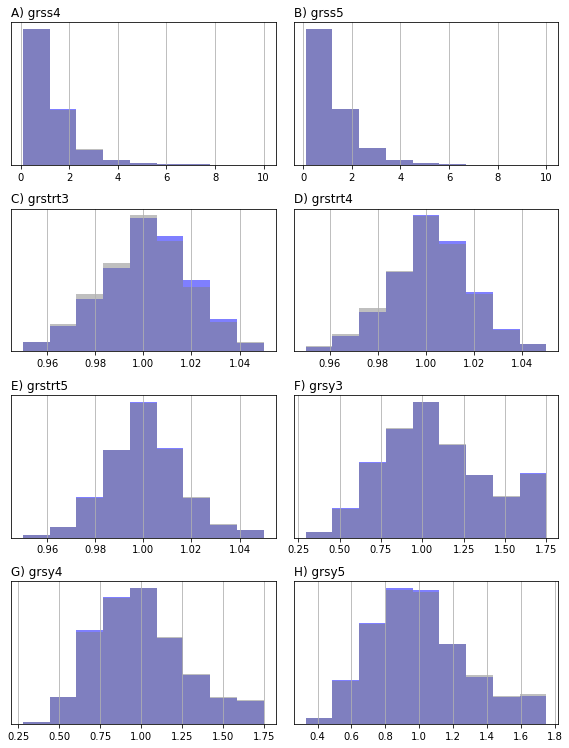

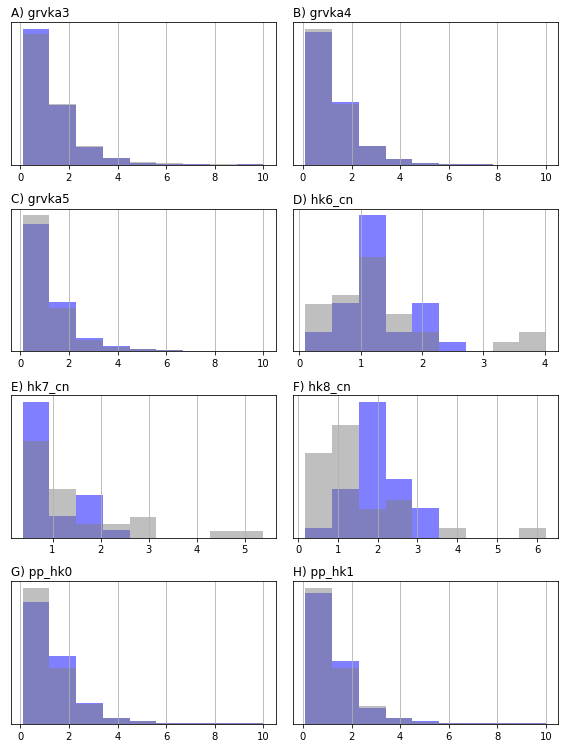

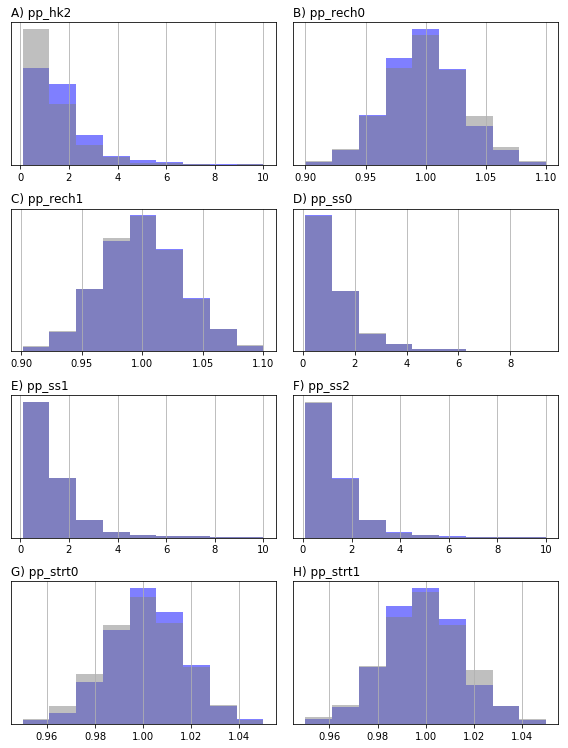

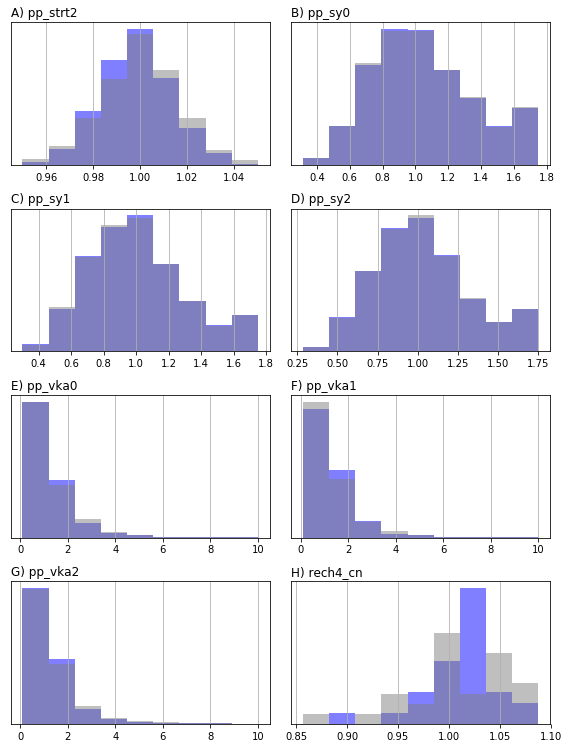

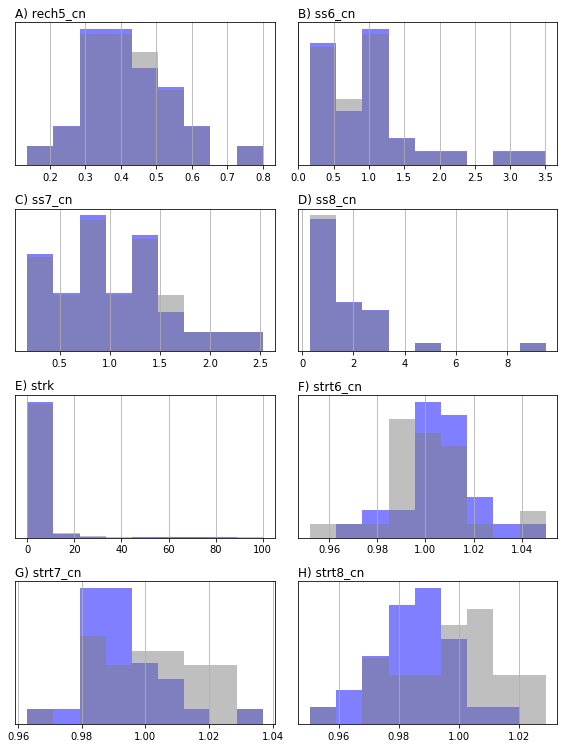

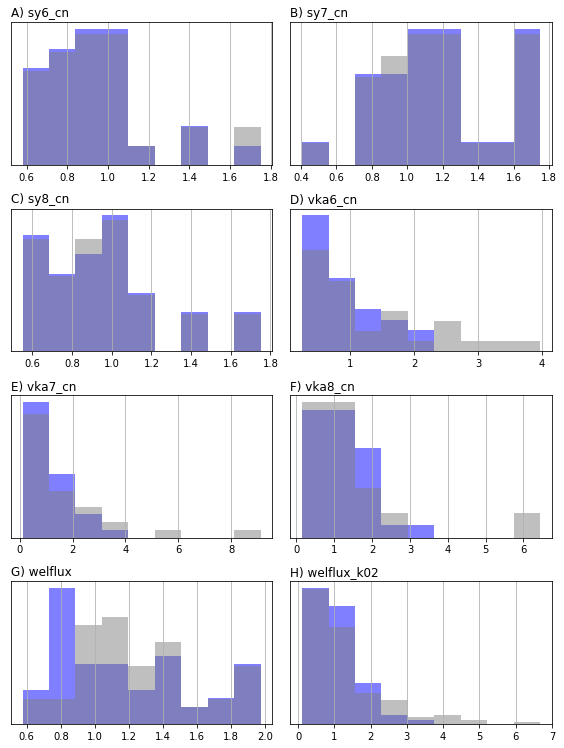

<Figure size 576x756 with 0 Axes>

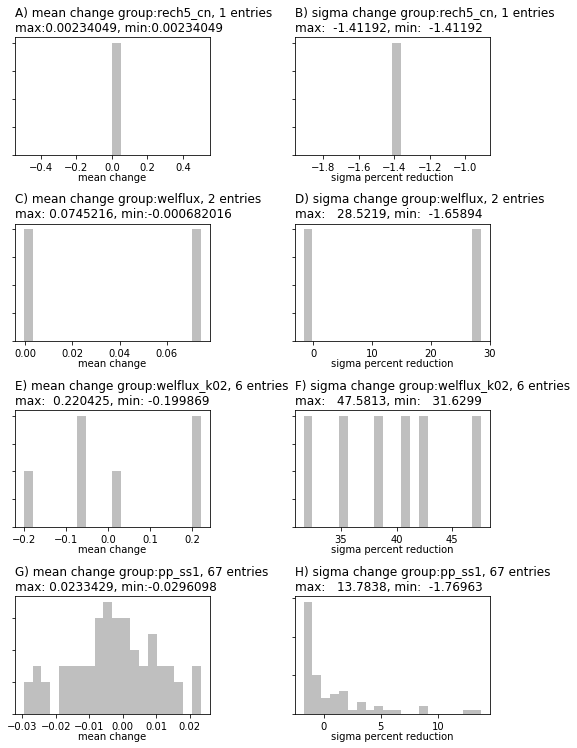

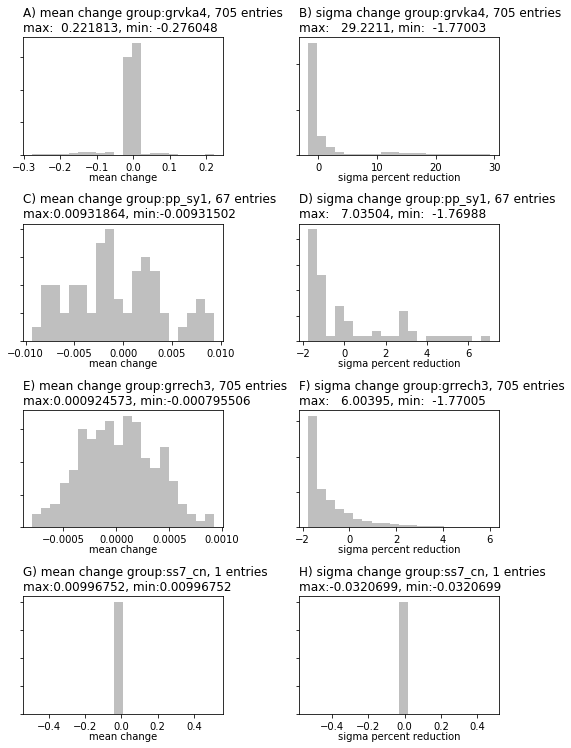

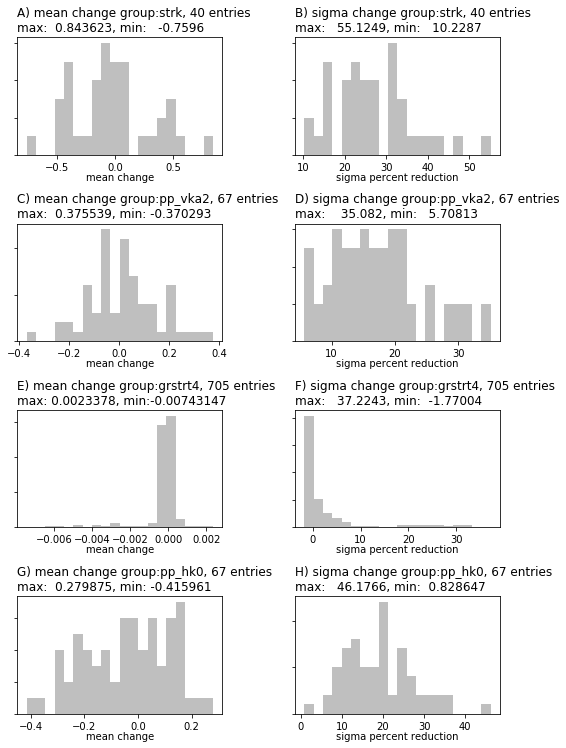

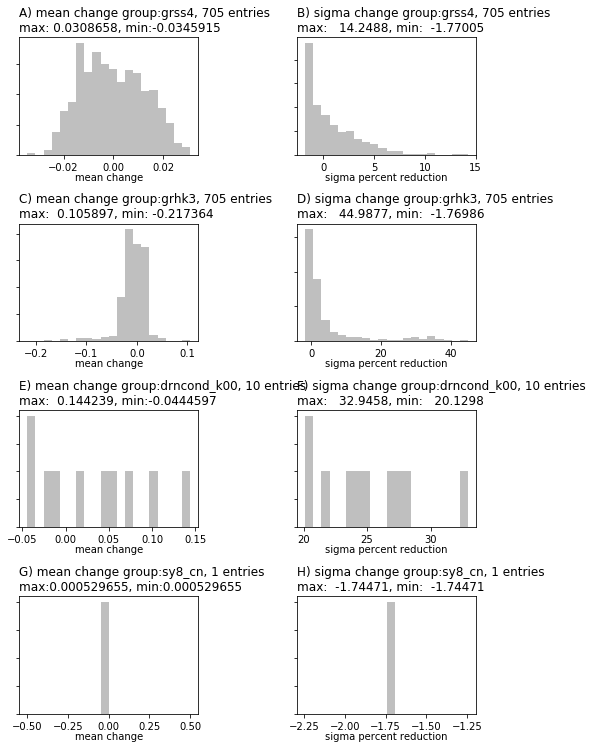

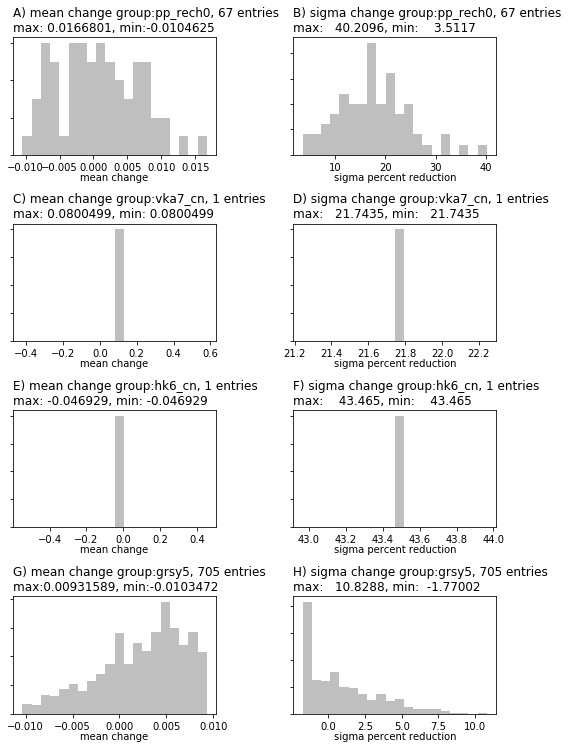

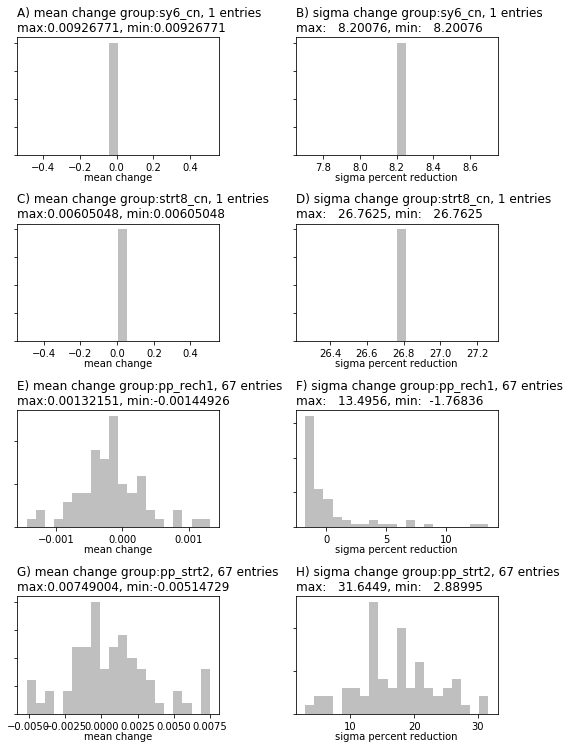

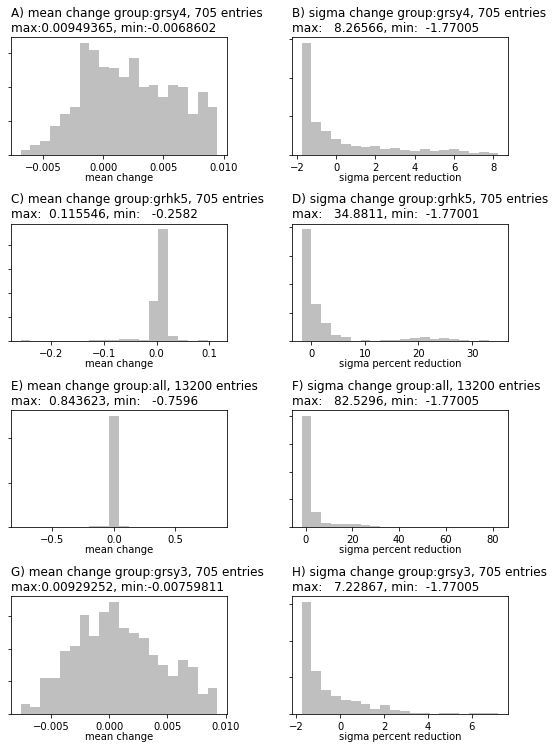

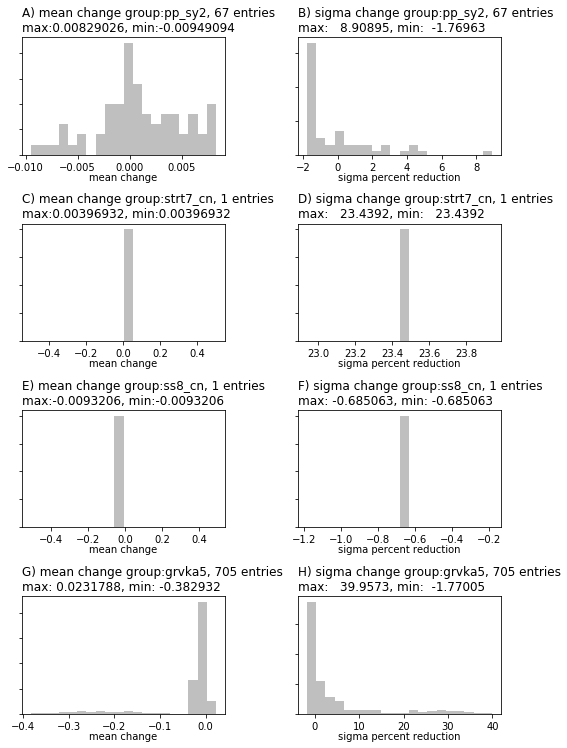

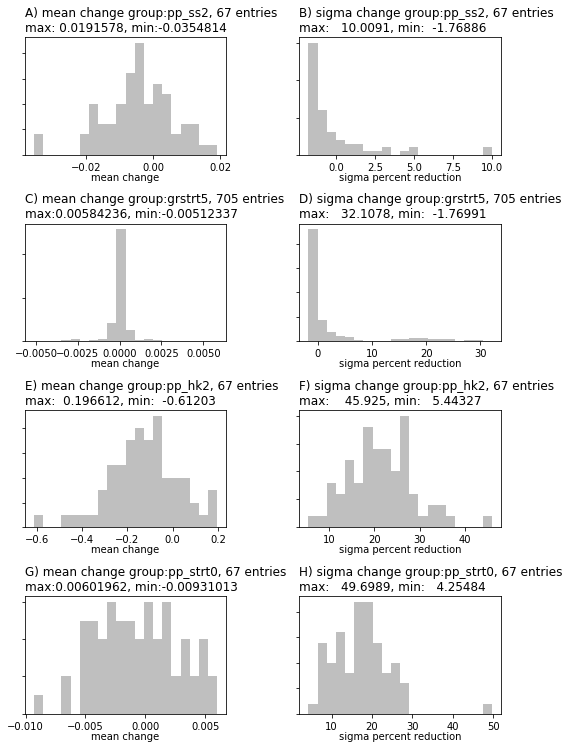

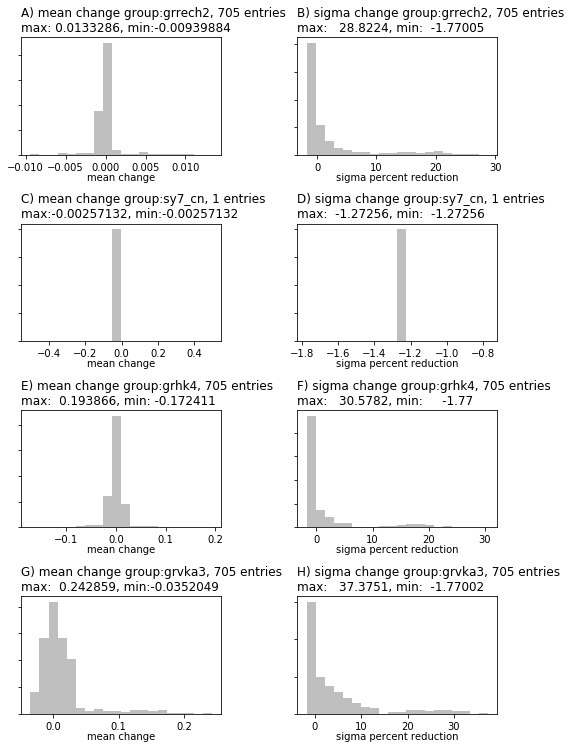

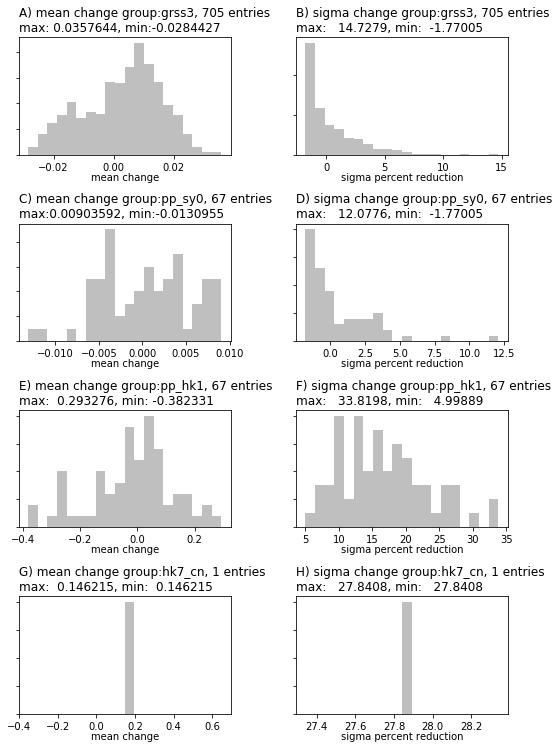

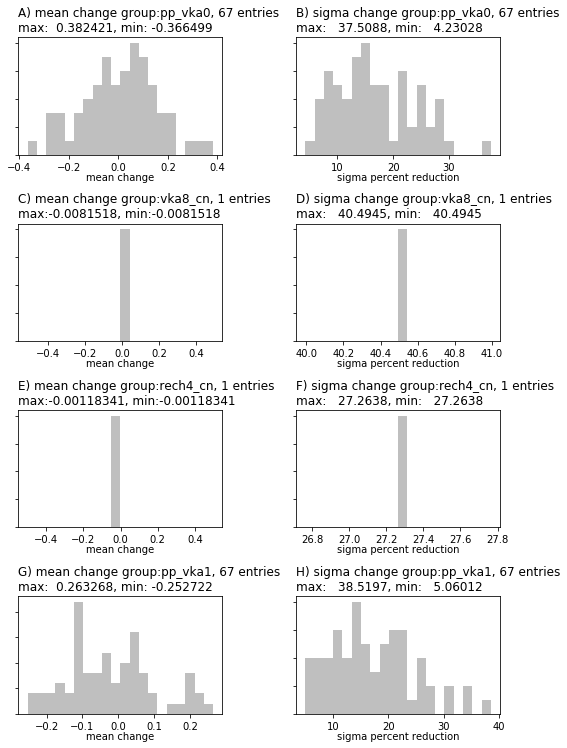

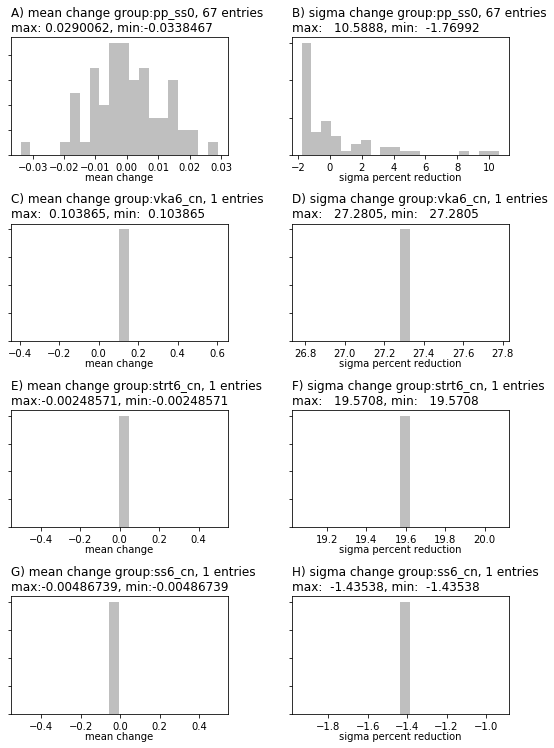

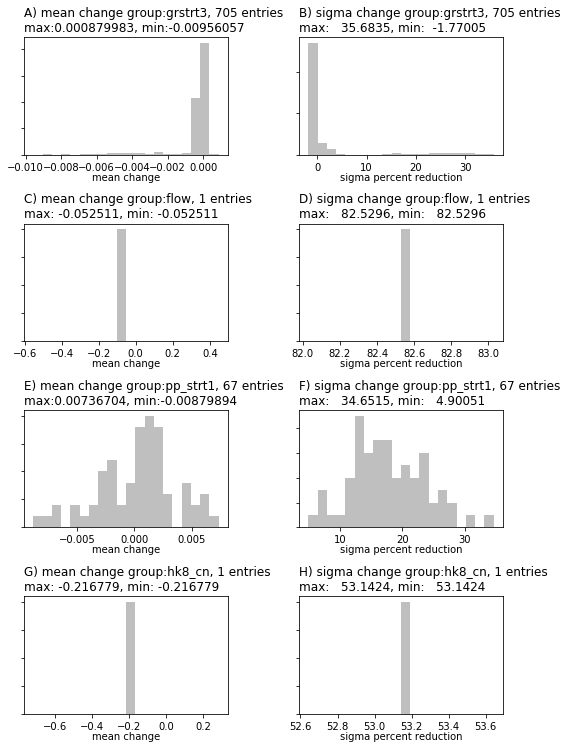

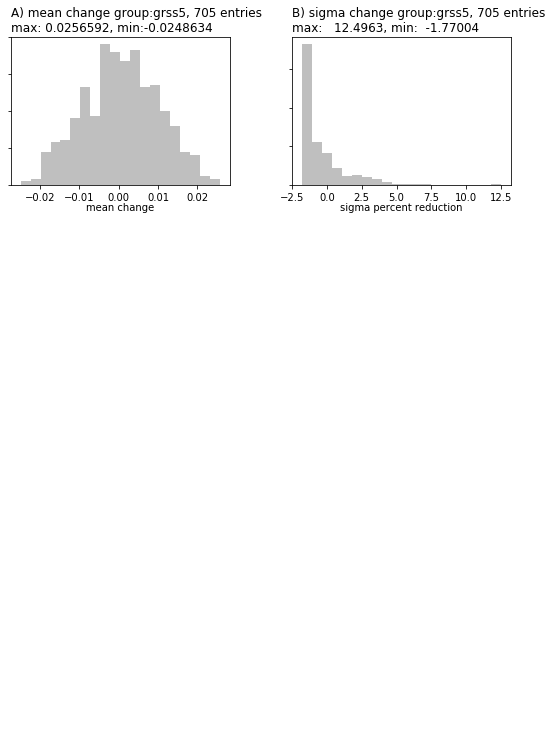

In [46]:
pe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies.0.par.csv"),index_col=0)
pe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies.{0}.par.csv".format(pst.control_data.noptmax)),index_col=0)
par = pst.parameter_data
pdict = par.groupby("pargp").groups
pyemu.plot_utils.ensemble_helper({"0.5":pe_pr,"b":pe_pt},plot_cols=pdict)
pyemu.plot_utils.ensemble_change_summary(pe_pr,pe_pt,pst=pst,bins=20)